In [16]:
from IPython.display import Markdown, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [17]:
# Display options
pd.set_option('display.max_columns', None)

# Matplotlib configuration
plt.style.use('classic')

In [18]:
# Auxiliary functions

def one_hot_encode_dataset(data: pd.DataFrame) -> pd.DataFrame:
    """
    One-hot encodes categorical variables in the dataset.

    Parameters:
    data (pd.DataFrame): Input dataset.

    Returns:
    pd.DataFrame: Encoded dataset.
    """
    # Identify categorical variables
    categorical_features = data.select_dtypes(include=['object']).columns

    # Apply one-hot encoding to the categorical variables
    encoded_data = pd.get_dummies(data, columns=categorical_features)

    return encoded_data


def map_categorical_features(data: pd.DataFrame) -> pd.DataFrame:
    """
    Maps categorical features in the dataset to predefined categories.

    Parameters:
    data (pd.DataFrame): Input dataset.

    Returns:
    pd.DataFrame: Dataset with mapped categorical features.
    """
    # Define mappings
    MSSubClass_mapping = {
        20: '1-STORY 1946 & NEWER ALL STYLES',
        30: '1-STORY 1945 & OLDER',
        40: '1-STORY W/FINISHED ATTIC ALL AGES',
        45: '1-1/2 STORY - UNFINISHED ALL AGES',
        50: '1-1/2 STORY FINISHED ALL AGES',
        60: '2-STORY 1946 & NEWER',
        70: '2-STORY 1945 & OLDER',
        75: '2-1/2 STORY ALL AGES',
        80: 'SPLIT OR MULTI-LEVEL',
        85: 'SPLIT FOYER',
        90: 'DUPLEX - ALL STYLES AND AGES',
        120: '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
        150: '1-1/2 STORY PUD - ALL AGES',
        160: '2-STORY PUD - 1946 & NEWER',
        180: 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
        190: '2 FAMILY CONVERSION - ALL STYLES AND AGES'
    }

    OverallQual_mapping = {
        10: 'Very Excellent',
        9: 'Excellent',
        8: 'Very Good',
        7: 'Good',
        6: 'Above Average',
        5: 'Average',
        4: 'Below Average',
        3: 'Fair',
        2: 'Poor',
        1: 'Very Poor'
    }

    OverallCond_mapping = OverallQual_mapping

    # Apply mappings
    data['MSSubClass'] = data['MSSubClass'].map(MSSubClass_mapping)
    data['OverallQual'] = data['OverallQual'].map(OverallQual_mapping)
    data['OverallCond'] = data['OverallCond'].map(OverallCond_mapping)

    return data


## **1.** Load train dataset
Load train dataset into workspace.

In [19]:
# Load train dataset
df = pd.read_csv('../data/train.csv')
df_html = df.head(5).to_html()
display(Markdown(f"#### **Dataset preview**\n{df_html} \n\n"))
display(Markdown(f"\n\nRows: {df.shape[0]}, Columns: {df.shape[1]}"))

#### **Dataset preview**
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Id</th>
      <th>MSSubClass</th>
      <th>MSZoning</th>
      <th>LotFrontage</th>
      <th>LotArea</th>
      <th>Street</th>
      <th>Alley</th>
      <th>LotShape</th>
      <th>LandContour</th>
      <th>Utilities</th>
      <th>LotConfig</th>
      <th>LandSlope</th>
      <th>Neighborhood</th>
      <th>Condition1</th>
      <th>Condition2</th>
      <th>BldgType</th>
      <th>HouseStyle</th>
      <th>OverallQual</th>
      <th>OverallCond</th>
      <th>YearBuilt</th>
      <th>YearRemodAdd</th>
      <th>RoofStyle</th>
      <th>RoofMatl</th>
      <th>Exterior1st</th>
      <th>Exterior2nd</th>
      <th>MasVnrType</th>
      <th>MasVnrArea</th>
      <th>ExterQual</th>
      <th>ExterCond</th>
      <th>Foundation</th>
      <th>BsmtQual</th>
      <th>BsmtCond</th>
      <th>BsmtExposure</th>
      <th>BsmtFinType1</th>
      <th>BsmtFinSF1</th>
      <th>BsmtFinType2</th>
      <th>BsmtFinSF2</th>
      <th>BsmtUnfSF</th>
      <th>TotalBsmtSF</th>
      <th>Heating</th>
      <th>HeatingQC</th>
      <th>CentralAir</th>
      <th>Electrical</th>
      <th>1stFlrSF</th>
      <th>2ndFlrSF</th>
      <th>LowQualFinSF</th>
      <th>GrLivArea</th>
      <th>BsmtFullBath</th>
      <th>BsmtHalfBath</th>
      <th>FullBath</th>
      <th>HalfBath</th>
      <th>BedroomAbvGr</th>
      <th>KitchenAbvGr</th>
      <th>KitchenQual</th>
      <th>TotRmsAbvGrd</th>
      <th>Functional</th>
      <th>Fireplaces</th>
      <th>FireplaceQu</th>
      <th>GarageType</th>
      <th>GarageYrBlt</th>
      <th>GarageFinish</th>
      <th>GarageCars</th>
      <th>GarageArea</th>
      <th>GarageQual</th>
      <th>GarageCond</th>
      <th>PavedDrive</th>
      <th>WoodDeckSF</th>
      <th>OpenPorchSF</th>
      <th>EnclosedPorch</th>
      <th>3SsnPorch</th>
      <th>ScreenPorch</th>
      <th>PoolArea</th>
      <th>PoolQC</th>
      <th>Fence</th>
      <th>MiscFeature</th>
      <th>MiscVal</th>
      <th>MoSold</th>
      <th>YrSold</th>
      <th>SaleType</th>
      <th>SaleCondition</th>
      <th>SalePrice</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1</td>
      <td>60</td>
      <td>RL</td>
      <td>65.0</td>
      <td>8450</td>
      <td>Pave</td>
      <td>NaN</td>
      <td>Reg</td>
      <td>Lvl</td>
      <td>AllPub</td>
      <td>Inside</td>
      <td>Gtl</td>
      <td>CollgCr</td>
      <td>Norm</td>
      <td>Norm</td>
      <td>1Fam</td>
      <td>2Story</td>
      <td>7</td>
      <td>5</td>
      <td>2003</td>
      <td>2003</td>
      <td>Gable</td>
      <td>CompShg</td>
      <td>VinylSd</td>
      <td>VinylSd</td>
      <td>BrkFace</td>
      <td>196.0</td>
      <td>Gd</td>
      <td>TA</td>
      <td>PConc</td>
      <td>Gd</td>
      <td>TA</td>
      <td>No</td>
      <td>GLQ</td>
      <td>706</td>
      <td>Unf</td>
      <td>0</td>
      <td>150</td>
      <td>856</td>
      <td>GasA</td>
      <td>Ex</td>
      <td>Y</td>
      <td>SBrkr</td>
      <td>856</td>
      <td>854</td>
      <td>0</td>
      <td>1710</td>
      <td>1</td>
      <td>0</td>
      <td>2</td>
      <td>1</td>
      <td>3</td>
      <td>1</td>
      <td>Gd</td>
      <td>8</td>
      <td>Typ</td>
      <td>0</td>
      <td>NaN</td>
      <td>Attchd</td>
      <td>2003.0</td>
      <td>RFn</td>
      <td>2</td>
      <td>548</td>
      <td>TA</td>
      <td>TA</td>
      <td>Y</td>
      <td>0</td>
      <td>61</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>0</td>
      <td>2</td>
      <td>2008</td>
      <td>WD</td>
      <td>Normal</td>
      <td>208500</td>
    </tr>
    <tr>
      <th>1</th>
      <td>2</td>
      <td>20</td>
      <td>RL</td>
      <td>80.0</td>
      <td>9600</td>
      <td>Pave</td>
      <td>NaN</td>
      <td>Reg</td>
      <td>Lvl</td>
      <td>AllPub</td>
      <td>FR2</td>
      <td>Gtl</td>
      <td>Veenker</td>
      <td>Feedr</td>
      <td>Norm</td>
      <td>1Fam</td>
      <td>1Story</td>
      <td>6</td>
      <td>8</td>
      <td>1976</td>
      <td>1976</td>
      <td>Gable</td>
      <td>CompShg</td>
      <td>MetalSd</td>
      <td>MetalSd</td>
      <td>NaN</td>
      <td>0.0</td>
      <td>TA</td>
      <td>TA</td>
      <td>CBlock</td>
      <td>Gd</td>
      <td>TA</td>
      <td>Gd</td>
      <td>ALQ</td>
      <td>978</td>
      <td>Unf</td>
      <td>0</td>
      <td>284</td>
      <td>1262</td>
      <td>GasA</td>
      <td>Ex</td>
      <td>Y</td>
      <td>SBrkr</td>
      <td>1262</td>
      <td>0</td>
      <td>0</td>
      <td>1262</td>
      <td>0</td>
      <td>1</td>
      <td>2</td>
      <td>0</td>
      <td>3</td>
      <td>1</td>
      <td>TA</td>
      <td>6</td>
      <td>Typ</td>
      <td>1</td>
      <td>TA</td>
      <td>Attchd</td>
      <td>1976.0</td>
      <td>RFn</td>
      <td>2</td>
      <td>460</td>
      <td>TA</td>
      <td>TA</td>
      <td>Y</td>
      <td>298</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>0</td>
      <td>5</td>
      <td>2007</td>
      <td>WD</td>
      <td>Normal</td>
      <td>181500</td>
    </tr>
    <tr>
      <th>2</th>
      <td>3</td>
      <td>60</td>
      <td>RL</td>
      <td>68.0</td>
      <td>11250</td>
      <td>Pave</td>
      <td>NaN</td>
      <td>IR1</td>
      <td>Lvl</td>
      <td>AllPub</td>
      <td>Inside</td>
      <td>Gtl</td>
      <td>CollgCr</td>
      <td>Norm</td>
      <td>Norm</td>
      <td>1Fam</td>
      <td>2Story</td>
      <td>7</td>
      <td>5</td>
      <td>2001</td>
      <td>2002</td>
      <td>Gable</td>
      <td>CompShg</td>
      <td>VinylSd</td>
      <td>VinylSd</td>
      <td>BrkFace</td>
      <td>162.0</td>
      <td>Gd</td>
      <td>TA</td>
      <td>PConc</td>
      <td>Gd</td>
      <td>TA</td>
      <td>Mn</td>
      <td>GLQ</td>
      <td>486</td>
      <td>Unf</td>
      <td>0</td>
      <td>434</td>
      <td>920</td>
      <td>GasA</td>
      <td>Ex</td>
      <td>Y</td>
      <td>SBrkr</td>
      <td>920</td>
      <td>866</td>
      <td>0</td>
      <td>1786</td>
      <td>1</td>
      <td>0</td>
      <td>2</td>
      <td>1</td>
      <td>3</td>
      <td>1</td>
      <td>Gd</td>
      <td>6</td>
      <td>Typ</td>
      <td>1</td>
      <td>TA</td>
      <td>Attchd</td>
      <td>2001.0</td>
      <td>RFn</td>
      <td>2</td>
      <td>608</td>
      <td>TA</td>
      <td>TA</td>
      <td>Y</td>
      <td>0</td>
      <td>42</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>0</td>
      <td>9</td>
      <td>2008</td>
      <td>WD</td>
      <td>Normal</td>
      <td>223500</td>
    </tr>
    <tr>
      <th>3</th>
      <td>4</td>
      <td>70</td>
      <td>RL</td>
      <td>60.0</td>
      <td>9550</td>
      <td>Pave</td>
      <td>NaN</td>
      <td>IR1</td>
      <td>Lvl</td>
      <td>AllPub</td>
      <td>Corner</td>
      <td>Gtl</td>
      <td>Crawfor</td>
      <td>Norm</td>
      <td>Norm</td>
      <td>1Fam</td>
      <td>2Story</td>
      <td>7</td>
      <td>5</td>
      <td>1915</td>
      <td>1970</td>
      <td>Gable</td>
      <td>CompShg</td>
      <td>Wd Sdng</td>
      <td>Wd Shng</td>
      <td>NaN</td>
      <td>0.0</td>
      <td>TA</td>
      <td>TA</td>
      <td>BrkTil</td>
      <td>TA</td>
      <td>Gd</td>
      <td>No</td>
      <td>ALQ</td>
      <td>216</td>
      <td>Unf</td>
      <td>0</td>
      <td>540</td>
      <td>756</td>
      <td>GasA</td>
      <td>Gd</td>
      <td>Y</td>
      <td>SBrkr</td>
      <td>961</td>
      <td>756</td>
      <td>0</td>
      <td>1717</td>
      <td>1</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>3</td>
      <td>1</td>
      <td>Gd</td>
      <td>7</td>
      <td>Typ</td>
      <td>1</td>
      <td>Gd</td>
      <td>Detchd</td>
      <td>1998.0</td>
      <td>Unf</td>
      <td>3</td>
      <td>642</td>
      <td>TA</td>
      <td>TA</td>
      <td>Y</td>
      <td>0</td>
      <td>35</td>
      <td>272</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>0</td>
      <td>2</td>
      <td>2006</td>
      <td>WD</td>
      <td>Abnorml</td>
      <td>140000</td>
    </tr>
    <tr>
      <th>4</th>
      <td>5</td>
      <td>60</td>
      <td>RL</td>
      <td>84.0</td>
      <td>14260</td>
      <td>Pave</td>
      <td>NaN</td>
      <td>IR1</td>
      <td>Lvl</td>
      <td>AllPub</td>
      <td>FR2</td>
      <td>Gtl</td>
      <td>NoRidge</td>
      <td>Norm</td>
      <td>Norm</td>
      <td>1Fam</td>
      <td>2Story</td>
      <td>8</td>
      <td>5</td>
      <td>2000</td>
      <td>2000</td>
      <td>Gable</td>
      <td>CompShg</td>
      <td>VinylSd</td>
      <td>VinylSd</td>
      <td>BrkFace</td>
      <td>350.0</td>
      <td>Gd</td>
      <td>TA</td>
      <td>PConc</td>
      <td>Gd</td>
      <td>TA</td>
      <td>Av</td>
      <td>GLQ</td>
      <td>655</td>
      <td>Unf</td>
      <td>0</td>
      <td>490</td>
      <td>1145</td>
      <td>GasA</td>
      <td>Ex</td>
      <td>Y</td>
      <td>SBrkr</td>
      <td>1145</td>
      <td>1053</td>
      <td>0</td>
      <td>2198</td>
      <td>1</td>
      <td>0</td>
      <td>2</td>
      <td>1</td>
      <td>4</td>
      <td>1</td>
      <td>Gd</td>
      <td>9</td>
      <td>Typ</td>
      <td>1</td>
      <td>TA</td>
      <td>Attchd</td>
      <td>2000.0</td>
      <td>RFn</td>
      <td>3</td>
      <td>836</td>
      <td>TA</td>
      <td>TA</td>
      <td>Y</td>
      <td>192</td>
      <td>84</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>0</td>
      <td>12</td>
      <td>2008</td>
      <td>WD</td>
      <td>Normal</td>
      <td>250000</td>
    </tr>
  </tbody>
</table> 





Rows: 1460, Columns: 81

## **2.** Random Forest Model
Random Forest analysis to assess the association between the predictor variable ***SalePrice*** and the other variables.

In [20]:
# TRAIN MODEL
# ------------------------------------------------------------------
split_ratio = 0.85

# Split the data into training and validation sets
Xtrain, Xval, Ytrain, Yval = train_test_split(df.drop(columns=['SalePrice']), 
                                                  df['SalePrice'], 
                                                  test_size=1-split_ratio)

# Drop 'Id' column
X_train = Xtrain.drop(columns=['Id'])
X_val = Xval.drop(columns=['Id'])

# Map dataset values to strings
X_train = map_categorical_features(X_train)
X_val = map_categorical_features(X_val)

# Perform one-hot encoding on the predictor variables
X_train = one_hot_encode_dataset(X_train)
X_val = one_hot_encode_dataset(X_val)

# Convert null values to zero
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)

# Instantiate and train the Random Forest Regressor model
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, Ytrain)

# Map features in validation dataset to match the features in training dataset
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

# Predict on the validation data
y_pred_val = random_forest.predict(X_val)

R^2 score: 0.9076429898339535


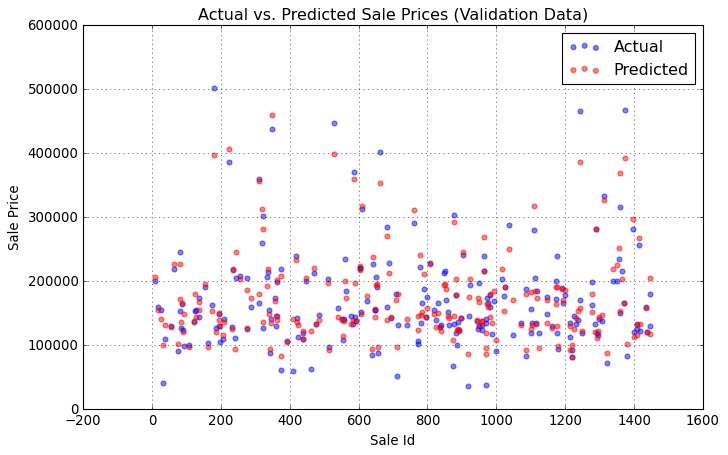

In [21]:
# Calculate R^2 score
r2 = r2_score(Yval, y_pred_val)
print("R^2 score:", r2)

# Plot predicted vs. actual prices
plt.figure(facecolor='white', figsize=(10, 6))
plt.scatter(Xval['Id'], Yval, color='blue', alpha=0.5, label='Actual')
plt.scatter(Xval['Id'], y_pred_val, color='red', alpha=0.5, label='Predicted')
plt.xlabel('Sale Id')
plt.ylabel('Sale Price')
plt.title('Actual vs. Predicted Sale Prices (Validation Data)')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# TEST MODEL
# ------------------------------------------------------------------
# Load test dataset
Xtest = pd.read_csv('../data/test.csv')

# Drop 'Id' column
X_test = Xtest.drop(columns=['Id'])

# Map dataset values to strings
X_test = map_categorical_features(X_test)

# Perform one-hot encoding on the predictor variables
X_test = one_hot_encode_dataset(X_test)

# Convert null values to zero
X_test = X_test.fillna(0)

# Map features in validation dataset to match the features in training dataset
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Generate predictions based on trained model
predictions = random_forest.predict(X_test)

# Save predicted prices for submission as CSV file
submission_df = pd.DataFrame({'Id': Xtest['Id'], 
                              'SalePrice': predictions})
submission_df.to_csv('../submission/randForest_submission.csv', index=False)

# Log message
print("Submission file successfully created!")

Submission file successfully created!


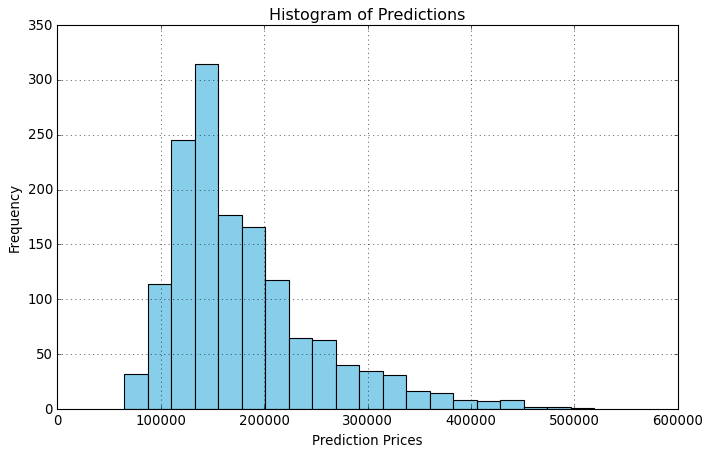

In [23]:
# Plot histogram for prediction values
plt.figure(facecolor='white', figsize=(10, 6))
plt.hist(predictions, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Predictions')
plt.xlabel('Prediction Prices')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()